In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import cifar10
from scipy.spatial.distance import cdist
from scipy.linalg import eigh

def spectral_clustering_segmentation(img, K, sigma=10.0):
    height, width, channel = img.shape
    N=height * width
    pixels = img.reshape(N, channel).astype(float)

    # Calculating conn matrix (RBF kernel)
    dists = cdist(pixels,pixels, metric='chebyshev')
    connection= np.exp(-(dists**2)/(2*sigma**2))

    #Degree matrix
    D = np.diag(connection.sum(axis=1))

    #Laplacian
    D_inv_sqrt = np.diag(1.0 /np.sqrt(np.diag(D)))
    L_sym= np.eye(N)- D_inv_sqrt @ connection @ D_inv_sqrt

    #k eigenvectors
    eigvals, eigvecs = eigh(L_sym)
    eigvecs_k = eigvecs[:, :K]

    #normalisation
    normed_eigvecs= eigvecs_k / np.linalg.norm(eigvecs_k, axis=1, keepdims=True)

    #kmeans
    kmeans = KMeans(n_clusters=K, random_state=40)
    labels = kmeans.fit_predict(normed_eigvecs)

    #alloting color
    cluster_means=np.array([pixels[labels == i].mean(axis=0) if np.any(labels == i) else np.zeros(3) for i in range(K)])
    segmented_img=cluster_means[labels].reshape(height, width, channel).astype(np.uint8)

    return segmented_img,labels,cluster_means

In [ ]:
(x_train, y_train), (_, _) = cifar10.load_data()

target_classes = [0,4,7]
x_train_filtered = x_train[np.isin(y_train, target_classes).flatten()]
y_train_filtered = y_train[np.isin(y_train, target_classes).flatten()]

In [ ]:
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [ ]:
def plot_spectral_segmentation(images,labels,K):
    num_images = len(images)
    fig, axes = plt.subplots(2, num_images, figsize=(5 * num_images, 8))

    for i, (img, label) in enumerate(zip(images, labels)):
        class_name = cifar10_labels[int(label)]
        img=cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
        segmented_img, _,centers = spectral_clustering_segmentation(img, K)
        centers = np.uint8(centers)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Original {class_name}", fontsize=10)
        axes[0, i].axis('off')
        axes[1, i].imshow(segmented_img)
        axes[1, i].set_title(f"Spectral Clustering (K={K})", fontsize=10)
        axes[1, i].axis('off')
        legend_elements =[Patch(facecolor=np.array(c) / 255.0, label=f'Cluster {j+1}')
                           for j, c in enumerate(centers)]
        axes[1,i].legend(handles=legend_elements,
                          loc='upper center',
                          bbox_to_anchor=(0.5, -0.15),
                          ncol=2,
                          fontsize=6,
                          frameon=False)

    plt.tight_layout()
    plt.show()

<ipython-input-181-2bb7c34d91a7>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_name = cifar10_labels[int(label)]
<ipython-input-181-2bb7c34d91a7>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_name = cifar10_labels[int(label)]
<ipython-input-181-2bb7c34d91a7>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_name = cifar10_labels[int(label)]


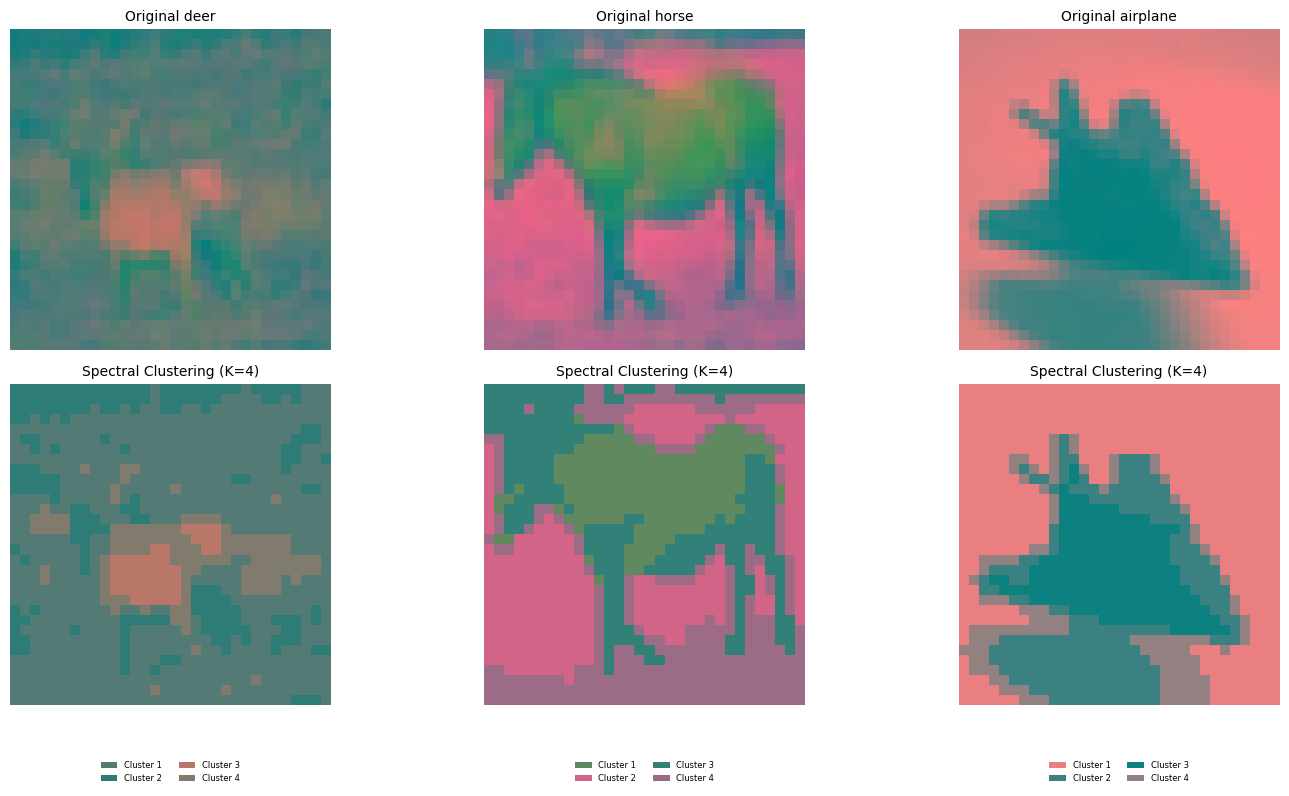

In [ ]:
imgss = x_train_filtered[:8]
lblss = y_train_filtered[:8]
test_images=[x_train_filtered[0],x_train_filtered[1],x_train_filtered[7]]
test_labels=[y_train_filtered[0],y_train_filtered[1],y_train_filtered[7]]
plot_spectral_segmentation(test_images,test_labels,K=4)

In [ ]:
from sklearn.metrics import silhouette_score

K = 2, Average Silhouette Score = 0.5952
K = 3, Average Silhouette Score = 0.5677
K = 4, Average Silhouette Score = 0.5395
K = 5, Average Silhouette Score = 0.5010
K = 6, Average Silhouette Score = 0.5030
K = 7, Average Silhouette Score = 0.4446
K = 8, Average Silhouette Score = 0.4356
K = 9, Average Silhouette Score = 0.4398
K = 10, Average Silhouette Score = 0.4408


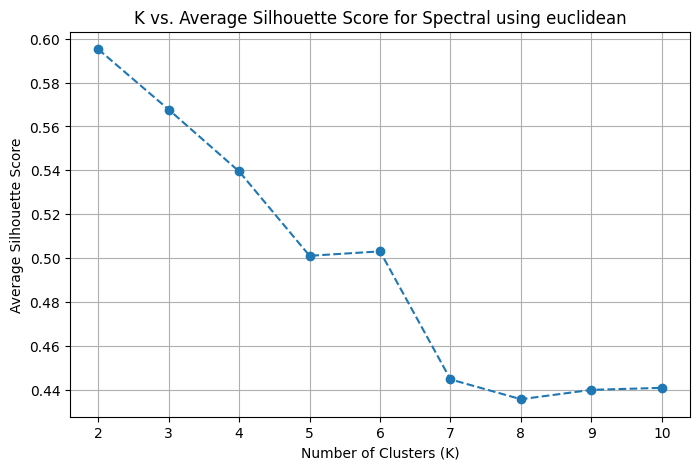

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

clusters = range(2, 11)
avg_silhouette_scores = []

for k in clusters:
    silhouette_scores = []
    for img in imgss:
        _,labels,_ = spectral_clustering_segmentation(img, k)
        X = img.reshape(-1, 3)
        silhouette = silhouette_score(X, labels)
        silhouette_scores.append(silhouette)
    avg_silhouette_scores.append(np.mean(silhouette_scores))

for k, score in zip(clusters, avg_silhouette_scores):
    print(f"K = {k}, Average Silhouette Score = {score:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(list(clusters), avg_silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.title('K vs. Average Silhouette Score for Spectral using euclidean')
plt.grid(True)
plt.show()


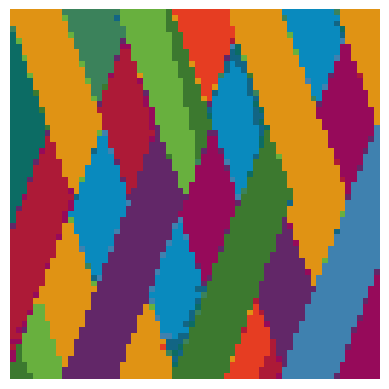

In [ ]:
import cv2
img=cv2.imread('/content/test1.jpg')
img=cv2.resize(img,(64,64))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
seg,cl,_=spectral_clustering_segmentation(img, K=12)
plt.imshow(seg)
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import cifar10
from scipy.spatial.distance import cdist
from scipy.linalg import eigh

def spectral_clustering_segmentation(img, metric,sigma=10.0):
    height, width, channel = img.shape
    N=height * width
    pixels = img.reshape(N, channel).astype(float)

    # Calculating conn matrix (RBF kernel)
    dists = cdist(pixels,pixels, metric=metric)
    connection= np.exp(-(dists**2)/(2*sigma**2))

    #Degree matrix
    D = np.diag(connection.sum(axis=1))

    #Laplacian
    D_inv_sqrt = np.diag(1.0 /np.sqrt(np.diag(D)))
    L_sym= np.eye(N)- D_inv_sqrt @ connection @ D_inv_sqrt

    #k eigenvectors
    eigvals, eigvecs = eigh(L_sym)
    eigvecs_k = eigvecs[:, :4]

    #normalisation
    normed_eigvecs= eigvecs_k / np.linalg.norm(eigvecs_k, axis=1, keepdims=True)

    #kmeans
    kmeans = KMeans(n_clusters=4, random_state=40)
    labels = kmeans.fit_predict(normed_eigvecs)

    #alloting color
    cluster_means = np.array([pixels[labels == i].mean(axis=0) if np.any(labels == i) else np.zeros(3) for i in range(4)])
    segmented_img = cluster_means[labels].reshape(height, width, channel).astype(np.uint8)

    return segmented_img,labels,cluster_means

**FOR K=4 trying diff metrics**

In [ ]:
imgss = x_train_filtered[:3]
lblss = y_train_filtered[:3]

K = euclidean, Average Silhouette Score = 0.4682
K = cityblock, Average Silhouette Score = 0.4067
K = sqeuclidean, Average Silhouette Score = 0.3208
K = canberra, Average Silhouette Score = 0.3516
K = braycurtis, Average Silhouette Score = 0.3626
K = chebyshev, Average Silhouette Score = 0.4709


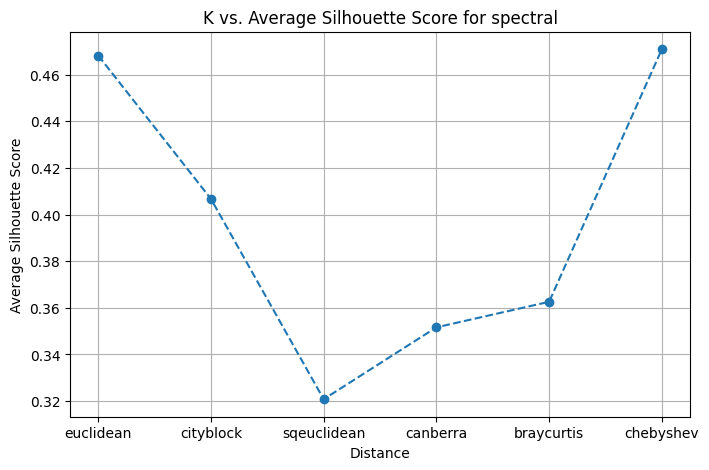

In [ ]:
metrics=['euclidean','cityblock','sqeuclidean','canberra','braycurtis','chebyshev']
import matplotlib.pyplot as plt
import numpy as np

avg_silhouette_scores = []

for m in metrics:
    silhouette_scores = []
    for img in imgss:
        _,labels,_ = spectral_clustering_segmentation(img,m)
        X = img.reshape(-1, 3)
        silhouette = silhouette_score(X, labels)
        silhouette_scores.append(silhouette)
    avg_silhouette_scores.append(np.mean(silhouette_scores))

for k, score in zip(metrics, avg_silhouette_scores):
    print(f"K = {k}, Average Silhouette Score = {score:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(metrics, avg_silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Distance')
plt.ylabel('Average Silhouette Score')
plt.title('K vs. Average Silhouette Score for spectral')
plt.grid(True)
plt.show()
